In [1]:
import numpy as np
import re

import pandas as pd
import seaborn as sns

/home/jmatsen/miniconda2/envs/neo4j/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 4, 2.5

The network directory in this share (which is still uploading, btw) contains a pickle (data.pkl) and the code used to generate it (network.py). The lfdr_pcor object in the pickle has the partial correlations after pruning, but poor has all of them (the full network). network.txt has a text version of the network (after pruning) that can be sucked into cytoscape.

The network data was calculated from mapping to genome bins:

In [3]:
network = pd.read_csv('/dacb/meta4_bins/analysis/network/network.txt', 
                      sep='\t')

In [4]:
network.head()

,source,target,weight,association
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive
1,Ga0081607_11219,Ga0081607_116221,0.01995,positive
2,Ga0081607_11219,Ga0081607_107914,0.02173,positive
3,Ga0081607_11219,Ga0081607_115213,0.02291,positive
4,Ga0081607_108214,Ga0081607_11235,0.01928,positive


In [5]:
network['target_organism'] = network['target'].str.extract('([A-z0-9]+)_[0-9]+')
network['target_gene'] = network['target'].str.extract('[A-z0-9]+_([0-9]+)')
network['source_organism'] = network['source'].str.extract('([A-z0-9]+)_[0-9]+')
network['source_gene'] = network['source'].str.extract('[A-z0-9]+_([0-9]+)')

/home/jmatsen/miniconda2/envs/neo4j/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/home/jmatsen/miniconda2/envs/neo4j/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app
/home/jmatsen/miniconda2/envs/neo4j/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/home/jmatsen/miniconda2/envs/neo4j/lib/python2.7/site-packages/ipykernel/__m

In [6]:
network.head()

,source,target,weight,association,target_organism,target_gene,source_organism,source_gene
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219
1,Ga0081607_11219,Ga0081607_116221,0.01995,positive,Ga0081607,116221,Ga0081607,11219
2,Ga0081607_11219,Ga0081607_107914,0.02173,positive,Ga0081607,107914,Ga0081607,11219
3,Ga0081607_11219,Ga0081607_115213,0.02291,positive,Ga0081607,115213,Ga0081607,11219
4,Ga0081607_108214,Ga0081607_11235,0.01928,positive,Ga0081607,11235,Ga0081607,108214


In [7]:
network = network.rename(columns=lambda x: re.sub('source$', 'source_locus_tag', x))
network = network.rename(columns=lambda x: re.sub('target$', 'target_locus_tag', x))

In [8]:
network.head(2)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219
1,Ga0081607_11219,Ga0081607_116221,0.01995,positive,Ga0081607,116221,Ga0081607,11219


In [9]:
network['target_organism'].unique()

array(['Ga0081607', 'Ga0081629'], dtype=object)

In [10]:
network['cross_species'] = network['source_organism'] != network['target_organism']

In [11]:
network.cross_species.describe()

count      2486
unique        2
top       False
freq       2252
Name: cross_species, dtype: object

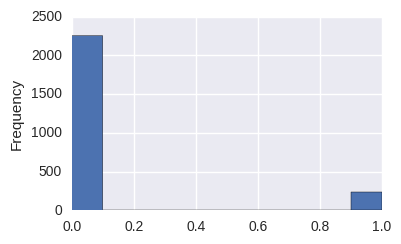

In [12]:
network.cross_species.plot.hist()

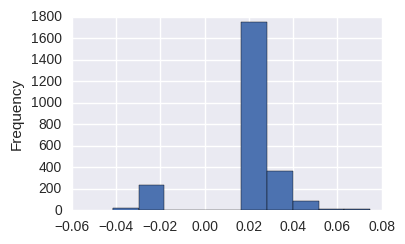

In [13]:
network.weight.plot.hist()

In [14]:
locus_to_organism = pd.read_csv('/dacb/meta4_bins/data/genome_bins.locus_to_organism.tsv', sep='\t',
                               names=['locus', 'organism'])

In [15]:
locus_to_organism.head()

,locus,organism
0,Ga0081607_1001,Methylobacter-123 (UID203)
1,Ga0081607_1002,Methylobacter-123 (UID203)
2,Ga0081607_1003,Methylobacter-123 (UID203)
3,Ga0081607_1004,Methylobacter-123 (UID203)
4,Ga0081607_1005,Methylobacter-123 (UID203)


In [16]:
# Found a problem: 
# Expected exactly 2 organsm names, but we have 3
#   {'Methylobacter-123 (UID203) ', 'Methylobacter-123 (UID203)', 'Methylotenera mobilis-49 (UID203)'}
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.strip.html
#   strips both left and right whitespace  :) 
locus_to_organism['organism'] = locus_to_organism['organism'].str.strip()

In [17]:
locus_to_organism['organism ID'] = locus_to_organism['locus'].str.extract('([A-z]+[0-9]+)_[0-9]+')

/home/jmatsen/miniconda2/envs/neo4j/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [18]:
source_organism_names = locus_to_organism[['organism ID', 'organism']].drop_duplicates()
target_organism_names = locus_to_organism[['organism ID', 'organism']].drop_duplicates()

In [19]:
source_organism_names = source_organism_names.rename(columns={'organism ID':'source_organism', 'organism':'source_organism_name'})
target_organism_names = target_organism_names.rename(columns={'organism ID':'target_organism', 'organism':'target_organism_name'})

In [20]:
source_organism_names

,source_organism,source_organism_name
0,Ga0081607,Methylobacter-123 (UID203)
260,Ga0081608,Methylotenera mobilis-123 (UID3888)
560,Ga0081609,Acidovorax-123 (UID4000)
578,Ga0081610,Rhodocyclaceae-127 (UID3972)
938,Ga0081611,Methylophilus methylotrophus-127-1 (UID203)
1080,Ga0081612,Methylophilus methylotrophus-127-2 (UID203)
1307,Ga0081613,Acidovorax-127 (UID4105)
1367,Ga0081614,Methylobacter tundripaludum-129 (UID203)
1454,Ga0081615,Opitutae-129 (UID2982)
1647,Ga0081616,Burkholderiales-129 (UID4000)


In [21]:
merged = pd.merge(network, source_organism_names)

In [22]:
merged.source_organism_name.unique()

array(['Methylobacter-123 (UID203)', 'Methylotenera mobilis-49 (UID203)'], dtype=object)

In [23]:
merged.head(2)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219,False,Methylobacter-123 (UID203)
1,Ga0081607_11219,Ga0081607_116221,0.01995,positive,Ga0081607,116221,Ga0081607,11219,False,Methylobacter-123 (UID203)


In [24]:
merged = pd.merge(merged, target_organism_names)
print(merged.shape)
print(network.shape)

(2486, 11)
(2486, 9)


In [25]:
merged.head()

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203)
1,Ga0081607_11219,Ga0081607_116221,0.01995,positive,Ga0081607,116221,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203)
2,Ga0081607_11219,Ga0081607_107914,0.02173,positive,Ga0081607,107914,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203)
3,Ga0081607_11219,Ga0081607_115213,0.02291,positive,Ga0081607,115213,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203)
4,Ga0081607_108214,Ga0081607_11235,0.01928,positive,Ga0081607,11235,Ga0081607,108214,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203)


In [26]:
merged.source_organism_name.unique()

array(['Methylobacter-123 (UID203)', 'Methylotenera mobilis-49 (UID203)'], dtype=object)

In [27]:
print(merged.shape)
print(network.shape)

(2486, 11)
(2486, 9)


In [28]:
merged.tail()

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
2481,Ga0081629_11451,Ga0081629_11135,0.03896,positive,Ga0081629,11135,Ga0081629,11451,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203)
2482,Ga0081629_11451,Ga0081629_12205,0.04051,positive,Ga0081629,12205,Ga0081629,11451,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203)
2483,Ga0081629_11451,Ga0081629_10266,0.04218,positive,Ga0081629,10266,Ga0081629,11451,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203)
2484,Ga0081629_11451,Ga0081629_11844,0.04379,positive,Ga0081629,11844,Ga0081629,11451,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203)
2485,Ga0081629_11451,Ga0081629_10632,0.04406,positive,Ga0081629,10632,Ga0081629,11451,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203)


In [29]:
# # d[(d['x']>2) & (d['y']>7)]
merged[(merged['source_organism_name'] == 'Methylotenera mobilis-49 (UID203)') &
       (merged['target_organism_name'] == 'Methylobacter-123 (UID203)')].head(2)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
1949,Ga0081629_12073,Ga0081607_11876,-0.01917,negative,Ga0081607,11876,Ga0081629,12073,True,Methylotenera mobilis-49 (UID203),Methylobacter-123 (UID203)
1950,Ga0081629_12073,Ga0081607_111619,0.02039,positive,Ga0081607,111619,Ga0081629,12073,True,Methylotenera mobilis-49 (UID203),Methylobacter-123 (UID203)


In [30]:
merged[(merged['source_organism_name'] == 'Methylobacter-123 (UID203)') &
       (merged['target_organism_name'] == 'Methylotenera mobilis-49 (UID203)')].head(2)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
2086,Ga0081607_108214,Ga0081629_10591,-0.02555,negative,Ga0081629,10591,Ga0081607,108214,True,Methylobacter-123 (UID203),Methylotenera mobilis-49 (UID203)
2087,Ga0081607_10701,Ga0081629_12205,0.02161,positive,Ga0081629,12205,Ga0081607,10701,True,Methylobacter-123 (UID203),Methylotenera mobilis-49 (UID203)


**Use summary_counts, not summary_rpkm for gene names.**

`jmatsen@waffle:/dacb/meta4_bins/analysis/assemble_summaries$ ag Ga0081607_11219 summary_rpkm.xls | head -n 10
jmatsen@waffle:/dacb/meta4_bins/analysis/assemble_summaries$ ag Ga0081607_11219 summary_counts.xls | head -n 10
2015:Methylobacter-123 (UID203)         Ga0081607_11219 hypothetical protein    243652  6660    160     285587  448     89      94      4893    13
        66994   47733   163     301     3       146     1851    26      53125   249288  21      14249   28      12      42296   23538   2778    1918      2061    217     173983  164307  398     450     1170    10410   30      344     2224    2164    1452    810     338     656     70      222       3475    1143    2672    1313    1246    930     54      23      9942    9603    2381    8196    29      49      23721   7808    33195   17291     5825    6609    36      83      40661   28629   17949   12227   15478   15054   125     1010    10214   66875   40225   944     11993   9572      56      9375`

In [31]:
genes = pd.read_csv('/dacb/meta4_bins/analysis/assemble_summaries/summary_counts.xls', sep = '\t', usecols=[1, 2])

In [32]:
genes.tail(3)

,locus_tag,product
169834,Ga0081655_13359,sulfur compound chelating protein SoxZ
169835,Ga0081655_133510,thiosulfate-binding protein SoxY
169836,Ga0081655_133511,predicted Zn-dependent protease


In [33]:
genes.tail()

,locus_tag,product
169832,Ga0081655_13357,alkyl hydroperoxide reductase subunit F
169833,Ga0081655_13358,peroxiredoxin (alkyl hydroperoxide reductase s...
169834,Ga0081655_13359,sulfur compound chelating protein SoxZ
169835,Ga0081655_133510,thiosulfate-binding protein SoxY
169836,Ga0081655_133511,predicted Zn-dependent protease


In [34]:
genes[genes['locus_tag'] == 'Ga0081607_11219']

,locus_tag,product
2013,Ga0081607_11219,hypothetical protein


In [35]:
merged.head(2)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203)
1,Ga0081607_11219,Ga0081607_116221,0.01995,positive,Ga0081607,116221,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203)


In [36]:
source_genes = genes[['locus_tag', 'product']].rename(columns={'locus_tag':'source_locus_tag', 'product':'source_gene_product'})
target_genes = genes[['locus_tag', 'product']].rename(columns={'locus_tag':'target_locus_tag', 'product':'target_gene_product'})

In [37]:
source_genes.head(2)

,source_locus_tag,source_gene_product
0,Ga0081607_10011,"DNA gyrase B subunit, carboxyl terminus"
1,Ga0081607_10012,Putative addiction module component


In [38]:
network.shape

(2486, 9)

In [39]:
merged.shape

(2486, 11)

In [40]:
merged = pd.merge(merged, source_genes)

In [41]:
merged.shape

(2486, 12)

In [42]:
merged = pd.merge(merged, target_genes)

In [43]:
merged.shape

(2486, 13)

In [44]:
merged.head(2)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name,source_gene_product,target_gene_product
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),hypothetical protein,flagellar protein FlaG
1,Ga0081607_115213,Ga0081607_115212,0.02512,positive,Ga0081607,115212,Ga0081607,115213,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),flagellin,flagellar protein FlaG


In [45]:
merged.head(3)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name,source_gene_product,target_gene_product
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),hypothetical protein,flagellar protein FlaG
1,Ga0081607_115213,Ga0081607_115212,0.02512,positive,Ga0081607,115212,Ga0081607,115213,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),flagellin,flagellar protein FlaG
2,Ga0081607_109111,Ga0081607_115212,0.01954,positive,Ga0081607,115212,Ga0081607,109111,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),bacterial nucleoid protein HU beta subunit,flagellar protein FlaG


In [46]:
merged['sort'] = merged.weight.abs()
merged = merged.sort(columns='sort', ascending=False).drop('sort', axis=1)

/home/jmatsen/miniconda2/envs/neo4j/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [47]:
merged['weight'].describe()

count    2486.000000
mean        0.020346
std         0.016258
min        -0.041380
25%         0.020020
50%         0.022290
75%         0.026930
max         0.074740
Name: weight, dtype: float64

In [48]:
merged.head(2)

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name,source_gene_product,target_gene_product
417,Ga0081607_113410,Ga0081607_10311,0.07474,positive,Ga0081607,10311,Ga0081607,113410,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),hypothetical protein,hypothetical protein
1808,Ga0081607_10311,Ga0081607_113410,0.07474,positive,Ga0081607,113410,Ga0081607,10311,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),hypothetical protein,hypothetical protein


In [49]:
merged['source_gene_product'].unique()[0:4]

array(['hypothetical protein', 'type IV pilus assembly protein PilA',
       'LSU ribosomal protein L35P',
       'nitric oxide reductase, NorC subunit apoprotein'], dtype=object)

In [50]:
filename = 'Methylobacter-123--Methylotenera_mobilis-49_network'

In [51]:
! ls ../data

gene_names.tsv		      network_broken.csv  network_with_info.txt
Methylobacter--Methylotenera  network_broken.tsv
network_broken_20.csv	      network.txt


In [52]:
! mkdir ../data/Methylobacter--Methylotenera

mkdir: cannot create directory ‘../data/Methylobacter--Methylotenera’: File exists


In [53]:
dirname = '../data/Methylobacter--Methylotenera/' 

In [54]:
merged.to_csv(dirname + filename + '.tsv', sep='\t', index=False)

In [55]:
# The CSV isn't a good idea because of the gene names. 
#merged.to_csv(dirname + filename + '.csv')

In [56]:
merged.head(100).to_csv(dirname + filename + '--100' + '.tsv', sep='\t', index=False)

In [57]:
merged.shape

(2486, 13)

In [58]:
top_genes = list(merged['source_gene_product'].unique()[0:3]) + list(merged['target_gene_product'].unique()[0:3])

In [59]:
has_top_genes = merged[(merged['source_gene_product'].isin(top_genes)) | (merged['target_gene_product'].isin(top_genes))]

In [60]:
has_top_genes.shape

(1268, 13)

In [61]:
has_top_genes.to_csv(dirname + filename + '--some_top_genes--1268_rows' + '.tsv', sep='\t', index=False)

## Make a file with just nodes.

Start with the merged stuff since I have to take the source and target nodes separately no matter which DF I start with.

In [62]:
merged.head()

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name,source_gene_product,target_gene_product
417,Ga0081607_113410,Ga0081607_10311,0.07474,positive,Ga0081607,10311,Ga0081607,113410,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),hypothetical protein,hypothetical protein
1808,Ga0081607_10311,Ga0081607_113410,0.07474,positive,Ga0081607,113410,Ga0081607,10311,False,Methylobacter-123 (UID203),Methylobacter-123 (UID203),hypothetical protein,hypothetical protein
1641,Ga0081629_11135,Ga0081629_10266,0.07207,positive,Ga0081629,10266,Ga0081629,11135,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203),hypothetical protein,type IV pilus assembly protein PilA
1360,Ga0081629_10266,Ga0081629_11135,0.07207,positive,Ga0081629,11135,Ga0081629,10266,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203),type IV pilus assembly protein PilA,hypothetical protein
1388,Ga0081629_11135,Ga0081629_12085,0.06670,positive,Ga0081629,12085,Ga0081629,11135,False,Methylotenera mobilis-49 (UID203),Methylotenera mobilis-49 (UID203),hypothetical protein,hypothetical protein


In [63]:
network.head()

,source_locus_tag,target_locus_tag,weight,association,target_organism,target_gene,source_organism,source_gene,cross_species
0,Ga0081607_11219,Ga0081607_115212,0.01928,positive,Ga0081607,115212,Ga0081607,11219,False
1,Ga0081607_11219,Ga0081607_116221,0.01995,positive,Ga0081607,116221,Ga0081607,11219,False
2,Ga0081607_11219,Ga0081607_107914,0.02173,positive,Ga0081607,107914,Ga0081607,11219,False
3,Ga0081607_11219,Ga0081607_115213,0.02291,positive,Ga0081607,115213,Ga0081607,11219,False
4,Ga0081607_108214,Ga0081607_11235,0.01928,positive,Ga0081607,11235,Ga0081607,108214,False


In [64]:
def extract_nodes(df, source=True):
    if source:
        string = 'source'
    else:
        string = 'target'
    cols = df.columns.str.contains(string)
    df_subset = df.iloc[:, cols]
    df_subset = df_subset.rename(columns=lambda x: x.replace(string + "_", ''))
    df_subset = df_subset.rename(columns=lambda x: x.replace(string, 'locus_tag'))
    return df_subset
    

In [65]:
extract_nodes(merged, True).head(3)

,locus_tag,organism,gene,organism_name,gene_product
417,Ga0081607_113410,Ga0081607,113410,Methylobacter-123 (UID203),hypothetical protein
1808,Ga0081607_10311,Ga0081607,10311,Methylobacter-123 (UID203),hypothetical protein
1641,Ga0081629_11135,Ga0081629,11135,Methylotenera mobilis-49 (UID203),hypothetical protein


In [66]:
extract_nodes(merged, False).head(3)

,locus_tag,organism,gene,organism_name,gene_product
417,Ga0081607_10311,Ga0081607,10311,Methylobacter-123 (UID203),hypothetical protein
1808,Ga0081607_113410,Ga0081607,113410,Methylobacter-123 (UID203),hypothetical protein
1641,Ga0081629_10266,Ga0081629,10266,Methylotenera mobilis-49 (UID203),type IV pilus assembly protein PilA


In [67]:
nodes = pd.concat([extract_nodes(merged, True).drop_duplicates(), 
                   extract_nodes(merged, False).drop_duplicates()], axis = 0)

In [68]:
nodes.shape

(510, 5)

In [69]:
nodes.drop_duplicates(inplace=True)

In [70]:
nodes.shape

(255, 5)

In [71]:
nodes.to_csv('../data/Methylobacter--Methylotenera/nodes.tsv', sep='\t', index=False)